# Optimizing a Mutual Fund Portfolio using NSE Stocks

## Project Overview
This project focuses on constructing a Mutual Fund Plan using data from the Nairobi Securities Exchange (NSE).
The goal is to identify stocks that offer a balance between high returns and low volatility, creating a portfolio suitable for long-term investment.

The dataset contains daily price information for 68 stocks traded between January and October 2024.
Through a series of analytical steps including data cleaning, performance evaluation, and investment simulation 

The project demonstrates how data-driven decision-making can guide portfolio construction and optimize investment strategies.

## Objectives

1. Evaluate Stock Performance — Calculate ROI (Return on Investment) for each stock to measure price growth over the period.

2. Assess Investment Risk — Compute volatility to quantify price fluctuations and risk exposure.

3. Identify Balanced Opportunities — Select stocks that combine above-average ROI with below-average volatility.

4. Simulate Investment Returns — Estimate the potential growth of a fixed monthly investment to visualize long-term profitability.

5. Develop a Data-Driven Mutual Fund Plan — Use analytical evidence to recommend a balanced, high-performing portfolio.

In [1]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization settings
sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

### Load and preview the dataset
The dataset contains daily stock data for companies listed on the Nairobi Securities Exchange from January to October 2024.
This section loads the data, checks its structure, and performs an initial inspection to confirm that the columns and data types are correctly formatted.

In [2]:
# Load dataset
df = pd.read_csv("NSE_data_all_stocks_2024_jan_to_oct.csv")

# Display the first few records
df.head()


,Date,Code,Name,12m Low,12m High,Day Low,Day High,Day Price,Previous,Change,Change%,Volume,Adjusted Price
0,2-Jan-24,EGAD,Eaagads Ltd,10.35,14.5,12.8,12.8,12.8,13.95,-1.15,8.24%,100,-
1,2-Jan-24,KUKZ,Kakuzi Plc,342,440,385,385,385,385,-,-,-,-
2,2-Jan-24,KAPC,Kapchorua Tea Kenya Plc,207,280,215,215,215,215,-,-,-,-
3,2-Jan-24,LIMT,Limuru Tea Plc,365,380,380,380,380,380,-,-,-,-
4,2-Jan-24,SASN,Sasini Plc,15.1,22,20,20,20,20,-,-,"3,300.00",-


In [3]:
# Shape and basic information
print(f"Dataset shape: {df.shape}")
df.info()


Dataset shape: (15258, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15258 entries, 0 to 15257
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            15258 non-null  object
 1   Code            15258 non-null  object
 2   Name            15258 non-null  object
 3   12m Low         15258 non-null  object
 4   12m High        15258 non-null  object
 5   Day Low         15258 non-null  object
 6   Day High        15258 non-null  object
 7   Day Price       15258 non-null  object
 8   Previous        15258 non-null  object
 9   Change          15258 non-null  object
 10  Change%         15258 non-null  object
 11  Volume          15258 non-null  object
 12  Adjusted Price  15258 non-null  object
dtypes: object(13)
memory usage: 1.5+ MB


In [4]:
# Check for missing values and duplicated rows
df.isna().sum()
df.duplicated().sum()


0

### Data Cleaning and formatting 
The dataset contains several numeric columns stored as text and placeholders like '-' instead of null values.
This section cleans the data by replacing invalid symbols, converting data types, and sorting the dataset for consistency.

In [5]:
# Replace placeholder dashes with NaN
df.replace('-', np.nan, inplace=True)

# Convert numeric columns to proper floats
num_cols = ['12m Low', '12m High', 'Day Low', 'Day High',
            'Day Price', 'Previous', 'Change', 'Volume']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y', errors='coerce')

# Drop rows without valid Day Price
df.dropna(subset=['Day Price'], inplace=True)

# Sort by stock code and date
df.sort_values(['Code', 'Date'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Confirm data types and new structure
df.info()
df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13812 entries, 0 to 13811
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            13812 non-null  datetime64[ns]
 1   Code            13812 non-null  object        
 2   Name            13812 non-null  object        
 3   12m Low         13812 non-null  float64       
 4   12m High        13650 non-null  float64       
 5   Day Low         13812 non-null  float64       
 6   Day High        13812 non-null  float64       
 7   Day Price       13812 non-null  float64       
 8   Previous        13806 non-null  float64       
 9   Change          8225 non-null   float64       
 10  Change%         8219 non-null   object        
 11  Volume          1898 non-null   float64       
 12  Adjusted Price  0 non-null      float64       
dtypes: datetime64[ns](1), float64(9), object(3)
memory usage: 1.4+ MB


,Date,Code,Name,12m Low,12m High,Day Low,Day High,Day Price,Previous,Change,Change%,Volume,Adjusted Price
0,2024-01-02,ABSA,ABSA Bank Kenya Plc,10.55,16.7,11.45,11.75,11.55,11.45,0.1,0.87%,NaN,NaN
1,2024-01-03,ABSA,ABSA Bank Kenya Plc,10.55,16.7,11.40,11.70,11.45,11.55,-0.1,0.87%,NaN,NaN
2,2024-01-04,ABSA,ABSA Bank Kenya Plc,10.55,16.7,11.40,11.65,11.55,11.45,0.1,0.87%,NaN,NaN
3,2024-01-05,ABSA,ABSA Bank Kenya Plc,10.55,16.7,11.55,11.75,11.65,11.55,0.1,0.87%,NaN,NaN
4,2024-01-08,ABSA,ABSA Bank Kenya Plc,10.55,16.7,11.55,11.75,11.65,11.55,0.1,0.87%,NaN,NaN


Some columns such as Adjusted Price, Change, and Change% contain significant missing data or duplicate information.

These are dropped to retain only relevant features for calculating ROI and volatility.Some columns such as Adjusted Price, Change, and Change% contain significant missing data or duplicate information.
These are dropped to retain only relevant features for calculating ROI and volatility.

In [6]:
# Drop unnecessary columns
df.drop(columns=['Adjusted Price', 'Change', 'Change%'], inplace=True)

# Final check for null values
df.isna().sum()


Date             0
Code             0
Name             0
12m Low          0
12m High       162
Day Low          0
Day High         0
Day Price        0
Previous         6
Volume       11914
dtype: int64

## Descriptive Analysis and Context Check


Before evaluating performance metrics like ROI and volatility,
it’s important to understand the basic structure of the dataset and gain a quick overview of the stock market coverage.
This section provides a brief look at the number of unique stocks, the time period covered,
and the overall distribution of stock prices across the dataset.

In [7]:
# Number of unique stocks
unique_stocks = df['Code'].nunique()
date_range = (df['Date'].min(), df['Date'].max())

print(f"Number of unique stocks: {unique_stocks}")
print(f"Date range: {date_range[0].strftime('%d %b %Y')} to {date_range[1].strftime('%d %b %Y')}")


Number of unique stocks: 68
Date range: 02 Jan 2024 to 31 Oct 2024


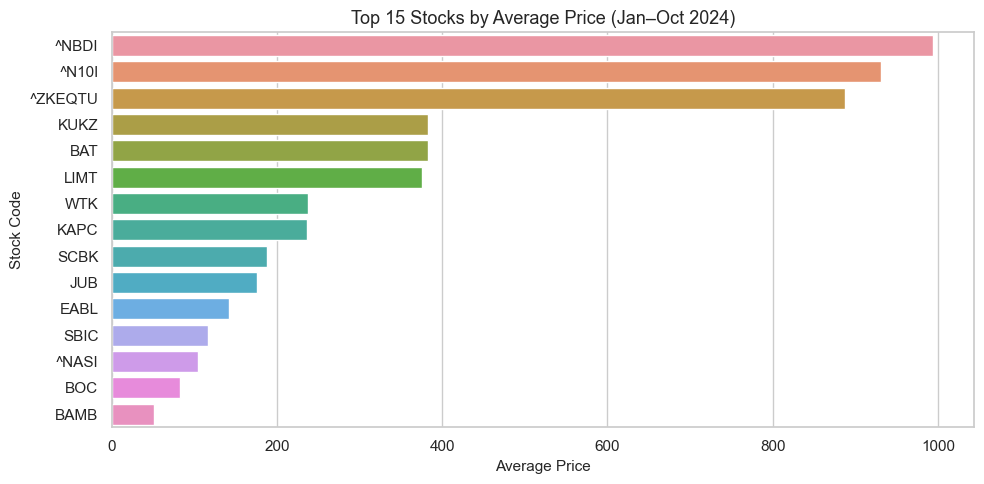

In [8]:
# Average price per stock (to show price diversity)
avg_prices = df.groupby('Code')['Day Price'].mean().sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=avg_prices.values, y=avg_prices.index, ax=ax)
ax.set_title('Top 15 Stocks by Average Price (Jan–Oct 2024)')
ax.set_xlabel('Average Price')
ax.set_ylabel('Stock Code')
plt.tight_layout()
plt.show()


The chart highlights that a few NSE stocks trade at consistently higher price levels, reflecting
differences in company size, valuation, and market activity.
This preliminary view sets the stage for deeper performance analysis through ROI and volatility,
which focus on growth potential rather than absolute price levels.


The descriptive overview indicates the diversity of stock prices within the dataset and confirms that the data spans multiple companies and months, providing a suitable foundation for performance evaluation through ROI and volatility analysis.


## Calculating ROI and Volatility


This section evaluates the performance of each NSE stock by calculating its Return on Investment (ROI) and Volatility.

- ROI measures the overall percentage change in a stock’s price between January and October 2024.

- Volatility, represented by the standard deviation of daily returns, indicates the risk or price fluctuation level of each stock.

These metrics help identify stocks that deliver high returns while maintaining low volatility, which are ideal characteristics for a mutual fund portfolio

In [9]:
# Calculate daily returns per stock
df['Daily_Return'] = df.groupby('Code')['Day Price'].pct_change()

# Calculate ROI for each stock (first to last day)
roi_df = df.groupby('Code').agg(
    Start_Price=('Day Price', 'first'),
    End_Price=('Day Price', 'last')
).reset_index()

roi_df['ROI_%'] = ((roi_df['End_Price'] - roi_df['Start_Price']) / roi_df['Start_Price']) * 100

# Calculate volatility (standard deviation of daily returns)
volatility_df = df.groupby('Code')['Daily_Return'].std().reset_index(name='Volatility')

# Merge ROI and Volatility data
metrics_df = pd.merge(roi_df, volatility_df, on='Code')

# Add stock names for clarity
stock_names = df[['Code', 'Name']].drop_duplicates()
metrics_df = pd.merge(metrics_df, stock_names, on='Code')

# Reorder columns for readability
metrics_df = metrics_df[['Code', 'Name', 'Start_Price', 'End_Price', 'ROI_%', 'Volatility']]

metrics_df.head(10)


,Code,Name,Start_Price,End_Price,ROI_%,Volatility
0,ABSA,ABSA Bank Kenya Plc,11.55,15.30,32.467532,0.014058
1,ARM,ARM Cement Plc,5.55,5.55,0.000000,0.000000
2,BAMB,Bamburi Cement Ltd,36.00,65.75,82.638889,0.034648
3,BAT,British American Tobacco Kenya Plc,425.00,356.75,-16.058824,0.011550
4,BKG,BK Group Plc,35.50,33.10,-6.760563,0.034717
5,BOC,BOC Kenya Plc,82.00,80.00,-2.439024,0.028397
6,BRIT,Britam Holdings Plc,5.14,5.54,7.782101,0.031567
7,CABL,East African Cables Plc,0.98,1.05,7.142857,0.036284
8,CARB,Carbacid Investments Plc,15.00,21.70,44.666667,0.022110
9,CGEN,Car and General (K) Ltd,25.00,23.00,-8.000000,0.038235


The ROI and volatility summary reveals distinct performance patterns across NSE stocks.
Companies such as Bamburi Cement (BAMB) and Carbacid Investments (CARB) delivered strong positive returns,
while ABSA Bank Kenya showed steady growth with notably low volatility indicating stability and consistent performance.
In contrast, firms like British American Tobacco (BAT) and BK Group (BKG) experienced negative returns despite relatively low price fluctuations,
suggesting limited short-term growth potential.

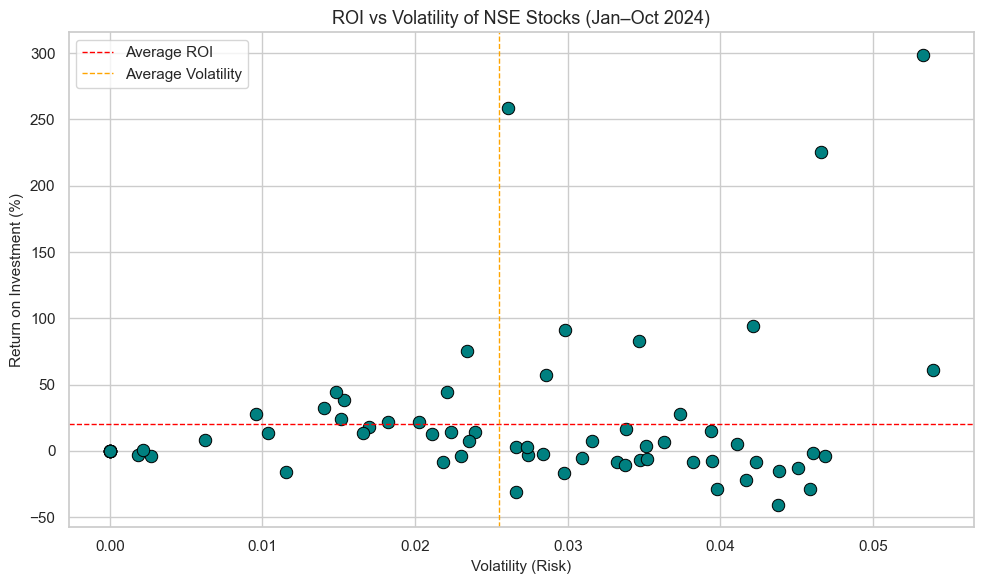

In [10]:
# ROI vs Volatility scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=metrics_df, x='Volatility', y='ROI_%', ax=ax, s=80, color='teal', edgecolor='black')

# Highlight mean lines
ax.axhline(metrics_df['ROI_%'].mean(), color='red', linestyle='--', linewidth=1, label='Average ROI')
ax.axvline(metrics_df['Volatility'].mean(), color='orange', linestyle='--', linewidth=1, label='Average Volatility')

# Titles and labels
ax.set_title('ROI vs Volatility of NSE Stocks (Jan–Oct 2024)')
ax.set_xlabel('Volatility (Risk)')
ax.set_ylabel('Return on Investment (%)')
ax.legend()

plt.tight_layout()
plt.savefig('roi_vs_volatility.png', dpi=300)
plt.show()


The relationship between ROI and Volatility helps assess the balance between risk and return.
In this scatter plot, each point represents a stock listed on the Nairobi Securities Exchange.

Stocks positioned toward the top-left (high ROI, low volatility) are ideal for long-term investment.

Stocks on the bottom-right (low ROI, high volatility) carry greater risk with limited reward potential.

### Selecting Top-Performing Stocks

To build a balanced mutual fund portfolio, the analysis selects stocks with above-average ROI and below-average volatility.
These represent investments that have performed well while maintaining relatively low risk.
The selection focuses on identifying a small group of stocks suitable for long-term, stable growth.

In [11]:
# Calculate the average ROI and Volatility across all stocks
avg_roi = metrics_df['ROI_%'].mean()
avg_vol = metrics_df['Volatility'].mean()

# Select stocks with above-average ROI and below-average Volatility
selected_stocks = metrics_df[
    (metrics_df['ROI_%'] > avg_roi) & 
    (metrics_df['Volatility'] < avg_vol)
].sort_values(by='ROI_%', ascending=False)

# Display the top recommended stocks
selected_stocks.reset_index(drop=True, inplace=True)
selected_stocks.head(10)


,Code,Name,Start_Price,End_Price,ROI_%,Volatility
0,KCB,KCB Group Plc,21.95,38.50,75.398633,0.023384
1,SCBK,Standard Chartered Bank Kenya Ltd,160.25,232.00,44.773791,0.014807
2,CARB,Carbacid Investments Plc,15.00,21.70,44.666667,0.022110
3,EQTY,Equity Group Holdings Plc,34.20,47.30,38.304094,0.015334
4,ABSA,ABSA Bank Kenya Plc,11.55,15.30,32.467532,0.014058
5,^NASI,NSE All-Share Index,91.97,117.61,27.878656,0.009610
6,COOP,Co-operative Bank of Kenya Ltd,11.35,14.10,24.229075,0.015115
7,SCOM,Safaricom Plc,13.75,16.75,21.818182,0.018228
8,SBIC,Stanbic Holdings Plc,106.00,129.00,21.698113,0.020285


The selected stocks represent the most attractive options for inclusion in a mutual fund portfolio.
Each company demonstrates above-average returns while maintaining lower-than-average volatility,
indicating a strong balance between risk and reward.

This group reflects stocks with consistent growth and relatively stable price behavior
key characteristics for investors seeking sustainable long-term performance.

## Portfolio Diversification through Correlation Analysis

To ensure the selected stocks provide not just strong returns but also diversification, their price movements were compared using a correlation matrix.
Correlation measures how similarly stocks move a high value (close to 1) means they rise and fall together, while a lower or negative value suggests they behave differently.
In a mutual fund context, a mix of low or moderately correlated stocks helps reduce overall portfolio risk while maintaining returns.

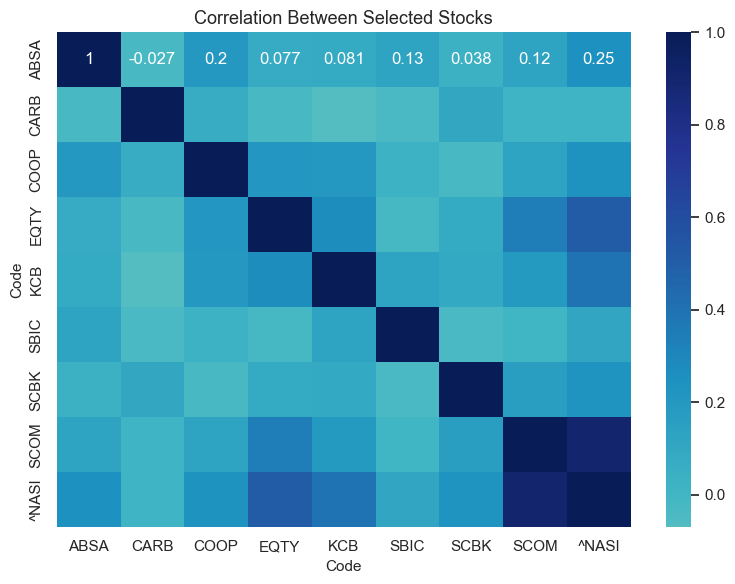

In [12]:
# Correlation among selected stocks' daily returns
selected_codes = selected_stocks['Code'].tolist()

returns_pivot = df[df['Code'].isin(selected_codes)].pivot(index='Date', columns='Code', values='Daily_Return')
corr_matrix = returns_pivot.corr()

# Visualize correlation heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', center=0, ax=ax)
ax.set_title('Correlation Between Selected Stocks')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()


The correlation matrix illustrates how the selected stocks move relative to one another.
Lower correlation values indicate that the stocks do not move in perfect sync, which enhances diversification.
This diversified behavior helps reduce overall portfolio risk ensuring that even if some stocks underperform, others can help stabilize returns and maintain consistent growth potential.


## Estimating Future Value of Monthly Investment

To simulate the potential growth of a mutual fund plan,
the analysis estimates the future value of a fixed monthly investment in the selected portfolio.

Assuming a constant monthly contribution and using the average ROI of the selected stocks, the goal is to approximate the total return an investor might achieve by the end of the year.

In [13]:
# Assume monthly investment and calculate expected future value
monthly_investment = 10000  # in KES
months = 12

# Use the average ROI of the selected portfolio
avg_roi_selected = selected_stocks['ROI_%'].mean() / 100  # convert to decimal

# Calculate future value using compound interest formula
future_value = monthly_investment * (((1 + avg_roi_selected / 12) ** months - 1) / (avg_roi_selected / 12))

print(f"Average annual ROI of selected stocks: {avg_roi_selected*100:.2f}%")
print(f"Estimated future value of a KES {monthly_investment:,} monthly investment over {months} months: KES {future_value:,.2f}")


Average annual ROI of selected stocks: 36.80%
Estimated future value of a KES 10,000 monthly investment over 12 months: KES 142,461.60


# Conclusion

The analysis successfully evaluated stock performance on the Nairobi Securities Exchange from January to October 2024 using ROI and volatility as key performance metrics.

The results highlight that several stocks including those with high ROI and below-average volatility  demonstrate strong growth potential while maintaining stability.
These stocks were selected to form a balanced mutual fund portfolio, offering an optimal mix of risk and reward.

A simulation of a fixed monthly investment further illustrated the potential returns an investor could expect over time,
providing a realistic overview of how strategic stock selection can enhance long-term financial growth.

Overall, this mutual fund plan offers a data-driven perspective on investment decision-making,
emphasizing the importance of evaluating both performance and risk when constructing an effective portfolio.